<a href="https://colab.research.google.com/github/noufalsalim/text_classification_keras/blob/master/text_classification_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

TensorFlow 1.x selected.


In [2]:
# categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']
categories = ['comp.graphics', 'sci.med']


from sklearn.datasets import fetch_20newsgroups
twenty_train = fetch_20newsgroups(subset='train',
                                  categories=categories, shuffle=True, random_state=42)

from keras.utils import to_categorical
twenty_train_label = to_categorical(twenty_train.target)

Using TensorFlow backend.


In [3]:
# elmo = hub.Module("https://tfhub.dev/google/elmo/3", trainable=True)

# def ElmoEmbedding(x):
#     return elmo(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["elmo"]

In [4]:
# Simple tokenization and vectorization based on word count, and pad the sequence to get fixed length
tokenizer = Tokenizer(num_words=None)
tokenizer.fit_on_texts(twenty_train.data) 
training_data_seq = tokenizer.texts_to_sequences(twenty_train.data) # converting to sequence

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
max_length = 100
embedding_dim = 50
training_data_seq = pad_sequences(training_data_seq, padding='post', maxlen=max_length) # zero padding

X_train, X_val, y_train, y_val = train_test_split(training_data_seq, twenty_train_label, test_size=0.20, random_state=0)

In [5]:
model = tf.keras.Sequential()
# model.add(keras.Input(shape=(1,), dtype=tf.string))
# model.add(layers.Lambda(ElmoEmbedding, output_shape=(1024, )))
model.add(layers.Embedding(vocab_size, embedding_dim))
model.add(layers.Dropout(0.2))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dropout(0.2))
# model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 50)          1246650   
_________________________________________________________________
dropout (Dropout)            (None, None, 50)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 50)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               6528      
_______________________________________________________

In [6]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    """
    plot the model accuracy details
    """
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

Train on 942 samples, validate on 236 samples
Epoch 1/200
942/942 [==============================] - 1s 796us/sample - loss: 0.6928 - acc: 0.5191 - val_loss: 0.6914 - val_acc: 0.5466
Epoch 2/200
942/942 [==============================] - 0s 304us/sample - loss: 0.6921 - acc: 0.5085 - val_loss: 0.6910 - val_acc: 0.5381
Epoch 3/200
942/942 [==============================] - 0s 314us/sample - loss: 0.6912 - acc: 0.5499 - val_loss: 0.6908 - val_acc: 0.5339
Epoch 4/200
942/942 [==============================] - 0s 329us/sample - loss: 0.6908 - acc: 0.5541 - val_loss: 0.6899 - val_acc: 0.5508
Epoch 5/200
942/942 [==============================] - 0s 299us/sample - loss: 0.6907 - acc: 0.5520 - val_loss: 0.6896 - val_acc: 0.5466
Epoch 6/200
942/942 [==============================] - 0s 306us/sample - loss: 0.6905 - acc: 0.5446 - val_loss: 0.6887 - val_acc: 0.5593
Epoch 7/200
942/942 [==============================] - 0s 308us/sample - loss: 0.6898 - acc: 0.5573 - val_loss: 0.6894 - val_acc: 0.

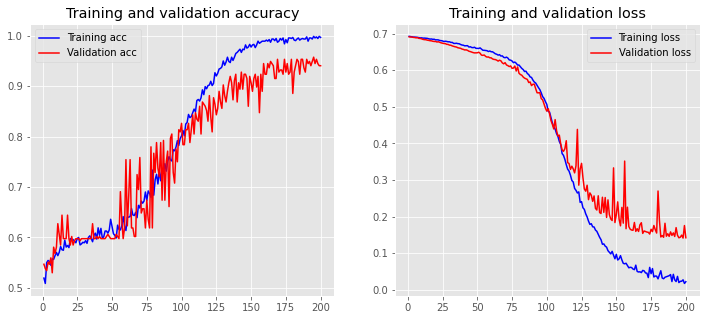

In [7]:
with tf.Session() as session:
    session.run(tf.compat.v1.global_variables_initializer())  
    session.run(tf.compat.v1.tables_initializer())
    history = model.fit(X_train, y_train,
                    epochs=200,
                    verbose=True,
                    validation_data=(X_val, y_val),
                    batch_size=10)
    model.save_weights('./model.h5')
    loss, accuracy = model.evaluate(np.array(X_train), np.array(y_train), verbose=True)
    print("Training Accuracy: {:.4f}".format(accuracy))
    loss, accuracy = model.evaluate(np.array(X_train), np.array(y_train), verbose=True)
    print("Testing Accuracy:  {:.4f}".format(accuracy))
    plot_history(history)